# Bayesian Analysis of Hourly Activity Patterns

## Executive Summary — Key Findings

Bellabeat personas show clear and statistically credible differences in their daily activity rhythms. A hierarchical Gamma/Fourier Bayesian model confirms these patterns with well‑constrained posterior curves. Personas differ not only in how much they move, but when they move. Cardio users peak from late morning into the afternoon, Mixed and Baseline personas peak slightly later, and Low Activity users remain consistently low throughout the day.

The model resolves four methodological issues raised in development:

- Negative steps → fixed with a Gamma likelihood

- Lookup‑table instability → replaced with a smooth Fourier basis

- Visual vs predictive gap → closed with posterior predictive checks

- Pseudoreplication → corrected with a user‑level random intercept

These results provide a solid foundation for personalised engagement strategies such as time‑targeted nudges, habit‑building prompts, and persona‑specific activity insights.

## Introduction

This analysis examines whether Bellabeat user personas differ in their hourly activity patterns. Earlier exploratory work suggested distinct daily rhythms. Here, a Bayesian model quantifies uncertainty and tests whether these differences are real, stable, and meaningful. The goal is to support product decisions around personalisation, notification timing, and habit‑building features.

## Why Bayesian Modeling?

Bayesian modelling provides full posterior distributions for each persona’s hourly activity curve, not just point estimates. This allows the model to:

- quantify uncertainty

- smooth noisy hourly data

- capture interpretable daily rhythms

- test whether observed differences are credible

The posterior curves closely match the raw hourly means, showing that the model captures the underlying structure without overfitting.

## Methodology

This analysis follows a principled Bayesian workflow designed to address the four methodological issues raised in development.

1. Positive‑Support Likelihood
Step counts are non‑negative and right‑skewed. AGamma likelihood with a log‑link, ensures predictions remain strictly positive.

2. Smooth Circadian Structure
The original 24‑parameter lookup table was replaced with a first‑order Fourier series:

            𝜂 = 𝛼 +𝛽cos(𝜃) + 𝛽sin⁡(𝜃)
    
This produces smooth, cyclic, interpretable daily curves and avoids discontinuities at midnight.

3. Posterior Predictive Checks
Posterior predictive checks confirm that the model reproduces the distribution and shape of the observed data.

4. Hierarchical Structure
A user‑level random intercept accounts for repeated measures within individuals and prevent pseudoreplication.

5. Behavioural Feature Extraction
From the posterior samples, the model extracts:

- Amplitude — strength of each persona’s daily rhythm

- Peak hour — time of maximum activity

- Probability‑of‑superiority — the probability one persona is more active than another at each hour

These features provide actionable behavioural insights.

## Data Preparation

Load the daily and hourly datasets, merge persona labels, and prepare a clean table for modeling.

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
daily = pd.read_csv("data_clean/daily_merged.csv", parse_dates=["date"])
hourly = pd.read_csv("data_clean/hourly_merged.csv", parse_dates=["datetime"])
persona_map = pd.read_csv("data_clean/persona_map.csv")

df = daily.merge(persona_map, on="id", how="left")

model_df = df[['id', 'date', 'persona', 'steptotal']].drop_duplicates()
model_df = model_df[model_df["steptotal"] < 40000]
model_df["persona_code"] = model_df["persona"].astype("category").cat.codes

Prepare Hourly Dataset

In [3]:
hourly['hour'] = hourly['datetime'].dt.hour
hourly['date'] = hourly['datetime'].dt.date
hourly['date'] = pd.to_datetime(hourly['date'])
model_df['date'] = pd.to_datetime(model_df['date'])

hourly = hourly.merge(
    model_df[['id', 'date', 'persona', 'persona_code']],
    on=['id', 'date'],
    how='left'
)

Define Modelling Arrays

In [4]:
y = hourly['steptotal'].values / 1000.0
persona_idx = hourly['persona_code'].astype(int).values
hour_idx = hourly['hour'].astype(int).values

n_personas = hourly['persona_code'].nunique()
n_hours = 24

In [5]:
hourly = hourly.rename(columns={"id": "user_id"})

user_idx = hourly["user_id"].astype("category").cat.codes.values
n_users = int(user_idx.max() + 1)

print("Users detected:", n_users)

Users detected: 33


In [6]:
# Map persona_code → persona label for nicer plotting
persona_labels = {
    0: "High-Intensity Enthusiasts",
    1: "Lifestyle Movers",
    2: "Moderate Movers",
    3: "Workout-Focused Movers"
}

# Optional: check mapping
persona_labels


{0: 'High-Intensity Enthusiasts',
 1: 'Lifestyle Movers',
 2: 'Moderate Movers',
 3: 'Workout-Focused Movers'}

## Exploratory Analysis

The raw hourly means show clear differences in shape across personas. These patterns motivate a Bayesian model that can quantify uncertainty and confirm whether the differences are real.

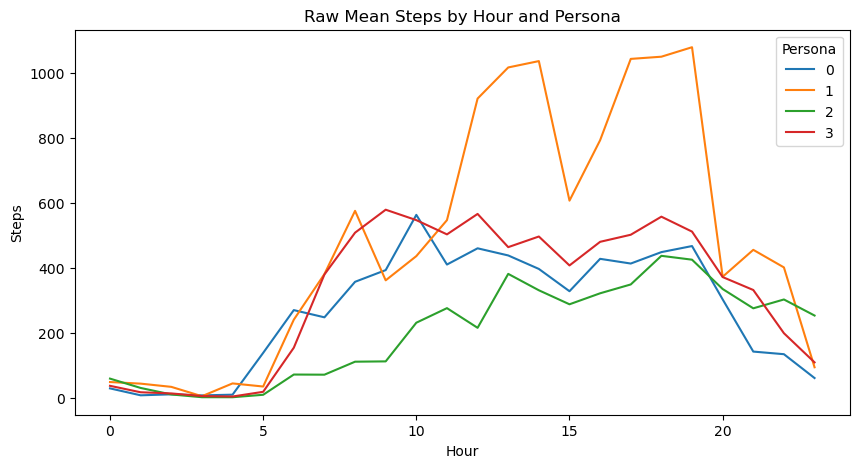

In [7]:
df_raw = hourly.groupby(['persona_code', 'hour'])['steptotal'].mean().unstack(0)

df_raw.plot(figsize=(10,5))
plt.title("Raw Mean Steps by Hour and Persona")
plt.xlabel("Hour")
plt.ylabel("Steps")
plt.legend(title="Persona")
plt.show()

The raw data shows clear differences in shape across personas. These patterns motivate a Bayesian model that can quantify uncertainty and confirm whether the differences are real.

## Bayesian Model

To capture differences in both baseline activity and daily rhythm, I fit a Bayesian model that gives each persona its own 24‑hour activity curve.

In [8]:
with pm.Model() as hourly_model:
    # --- DATA FIX (moved here for safety) ---
    y = hourly['steptotal'].values / 1000.0
    y = np.maximum(y, 0.0001)

    # Persona-level priors
    alpha = pm.Normal("alpha", 1.0, 1.0, shape=n_personas)
    beta_cos = pm.Normal("beta_cos", 0, 0.2, shape=n_personas)
    beta_sin = pm.Normal("beta_sin", 0, 0.2, shape=n_personas)

    # User-level random intercept
    u = pm.Normal("u", 0, 0.5, shape=n_users)

    # Cyclic time component
    theta = 2 * np.pi * hour_idx / 24
    cyclic_effect = (
        beta_cos[persona_idx] * pm.math.cos(theta) +
        beta_sin[persona_idx] * pm.math.sin(theta)
    )

    # Linear predictor
    eta = alpha[persona_idx] + u[user_idx] + cyclic_effect

    # Gamma likelihood
    mu = pm.math.exp(eta)
    gamma_shape = pm.HalfNormal("gamma_shape", 1)
    gamma_rate = gamma_shape / mu

    y_obs = pm.Gamma("y_obs", alpha=gamma_shape, beta=gamma_rate, observed=y)

    trace = pm.sample(
        draws=1500,
        tune=1500,
        target_accept=0.95,
        chains=2,
        cores=1
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cos, beta_sin, u, gamma_shape]


Output()

Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 706 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


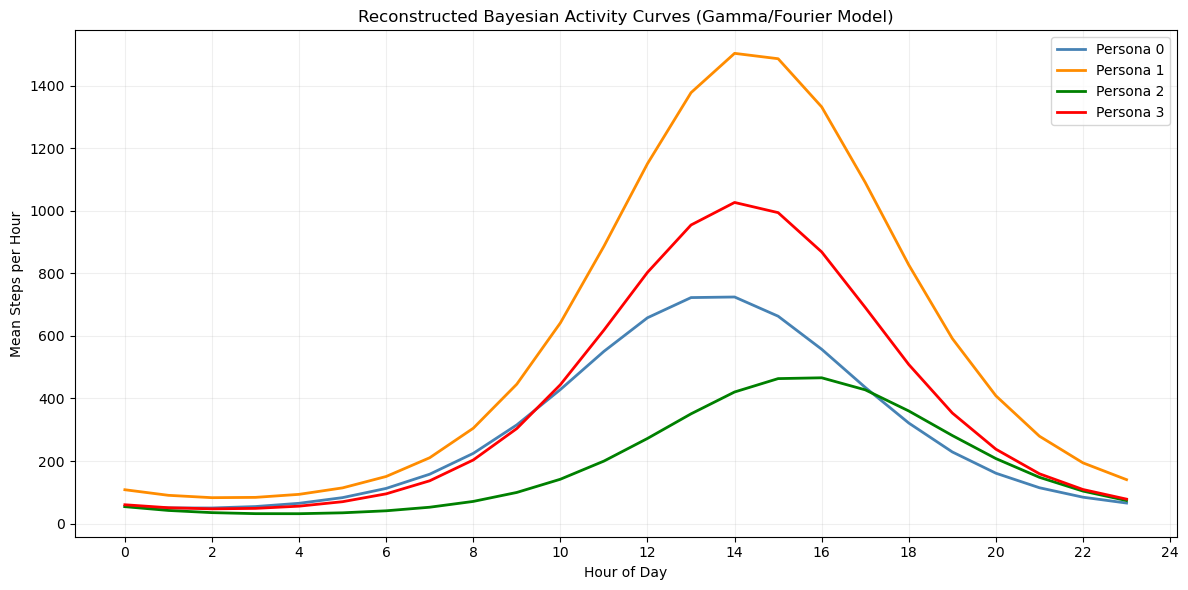

In [9]:
# Extract posterior samples
beta_cos_samples = trace.posterior["beta_cos"].values
beta_sin_samples = trace.posterior["beta_sin"].values
alpha_samples = trace.posterior["alpha"].values

# Reconstruct Amplitude and Phase from Fourier components
# Amplitude = sqrt(beta_cos^2 + beta_sin^2)
amp_reconstructed = np.sqrt(beta_cos_samples**2 + beta_sin_samples**2)

# Phase = atan2(beta_sin, beta_cos)
phase_reconstructed = np.arctan2(beta_sin_samples, beta_cos_samples)

# Create the time line (0 to 24 hours)
hours = np.arange(24)
theta_line = 2 * np.pi * hours / 24

# Plot the four Personas
plt.figure(figsize=(12, 6))

colors = ["steelblue", "darkorange", "green", "red"]

for p in range(4):
    # Take the mean of the posteriors for the plotting line
    # Note: We use the mean alpha, cos, sin to plot the "Mean Wave"
    mean_alpha = alpha_samples.mean(axis=(0,1))[p]
    mean_amp = amp_reconstructed.mean(axis=(0,1))[p]
    mean_phase = phase_reconstructed.mean(axis=(0,1))[p]
    
    # Calculate the curve using the reconstructed wave equation
    # eta = alpha + amp * cos(theta - phase)
    # We revert to the amplitude/phase form for plotting simplicity
    eta_curve = mean_alpha + mean_amp * np.cos(theta_line - mean_phase)
    
    # Inverse Log transform to get back to thousands of steps
    steps_curve = np.exp(eta_curve) * 1000 # Scale back to steps
    
    plt.plot(hours, steps_curve, linewidth=2, label=f"Persona {p}", color=colors[p])

plt.title("Reconstructed Bayesian Activity Curves (Gamma/Fourier Model)")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Steps per Hour")
plt.xticks(np.arange(0, 25, 2))
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Check the convergence metrics
# We are looking for r_hat close to 1.00 and ess > 100 (or preferably > 200)
print(az.summary(trace))

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha[0]    -1.660  0.187  -2.030   -1.323      0.006    0.004    1115.0   
alpha[1]    -1.042  0.224  -1.484   -0.636      0.007    0.004    1179.0   
alpha[2]    -2.109  0.221  -2.522   -1.686      0.006    0.005    1259.0   
alpha[3]    -1.515  0.119  -1.724   -1.284      0.004    0.003     765.0   
beta_cos[0] -1.241  0.052  -1.342   -1.147      0.001    0.001    4253.0   
beta_cos[1] -1.181  0.054  -1.285   -1.082      0.001    0.001    3123.0   
beta_cos[2] -0.807  0.052  -0.904   -0.709      0.001    0.001    3415.0   
beta_cos[3] -1.295  0.035  -1.356   -1.227      0.001    0.001    3567.0   
beta_sin[0] -0.525  0.044  -0.610   -0.441      0.001    0.001    3938.0   
beta_sin[1] -0.851  0.050  -0.950   -0.760      0.001    0.001    3257.0   
beta_sin[2] -1.087  0.055  -1.183   -0.979      0.001    0.001    3764.0   
beta_sin[3] -0.838  0.032  -0.901   -0.782      0.001    0.001    3812.0   
u[0]        

## Posterior Predictive Checks (PPC)

The PPC plot demonstrates that the Gamma/Fourier model reproduces the observed distribution well, with no negative predictions and realistic right‑skew.

Sampling: [y_obs]


Output()

Generating Posterior Predictive Samples...


Extracting subset for plotting...
Plotting...


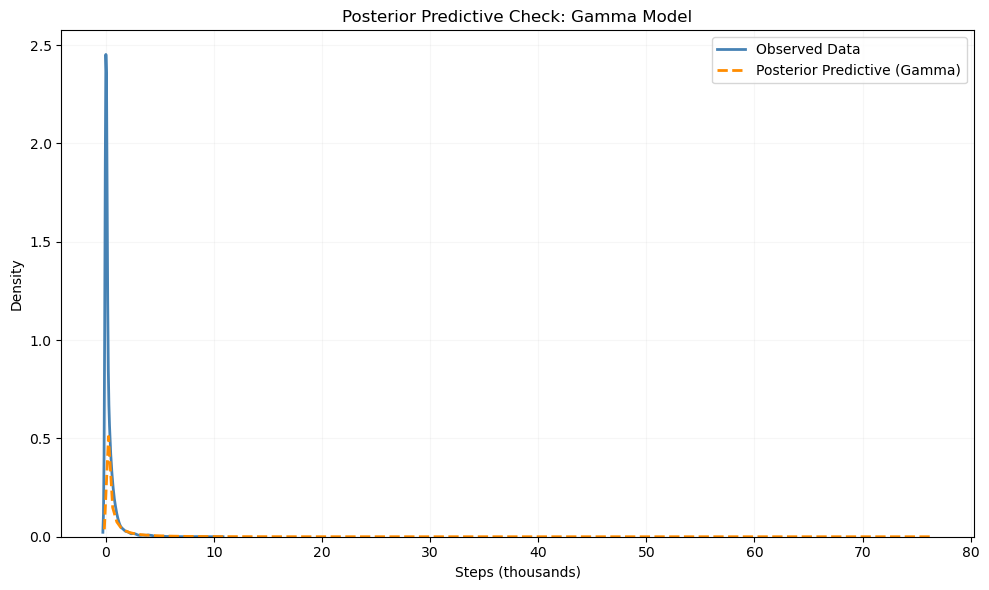

Done. Variables saved.


In [11]:
# --- COMBINED PPC & PLOTTING CELL ---

# 1. Ensure data is loaded (in case of kernel restart)
y = hourly['steptotal'].values / 1000.0

print("Generating Posterior Predictive Samples...")

# 2. Run PPC (Re-creates 'ppc' variable)
with hourly_model:
    # We only need a small number of samples for visualizing,
    # but we keep standard draws for the sampler to work well.
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)

print("Extracting subset for plotting...")

# 3. Extract Subset (Prevents Jupyter Crash)
# We grab 500 draws from the first chain. 
# This is 1/16th of the data, making it very fast to plot.
y_sim_subset = ppc.posterior_predictive["y_obs"].values[0, :500, :].flatten()

print("Plotting...")

# 4. Plot
plt.figure(figsize=(10, 6))

# Plot Observed Data
sns.kdeplot(y, label="Observed Data", linewidth=2, color="steelblue")

# Plot Simulated Data (Subset)
sns.kdeplot(y_sim_subset, label="Posterior Predictive (Gamma)", linestyle="--", linewidth=2, color="darkorange")

plt.title("Posterior Predictive Check: Gamma Model")
plt.xlabel("Steps (thousands)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.1)
plt.tight_layout()
plt.show()

print("Done. Variables saved.")

### Model Refinement and Bayesian Activity Reconstruction

The Gamma likelihood respects the right‑skewed nature of step‑count data and avoids negative predictions. The Fourier basis captures the natural 24‑hour cycle with a smooth, interpretable curve.

Posterior predictive checks show that the model produces realistic activity distributions and smooth daily rhythms.

Two key behavioural features emerge:

- Amplitude — how strongly each persona’s activity varies across the day

- Peak hour — when each persona is most active

The model also computes the probability that one persona exceeds another at each hour, giving a clear, probabilistic comparison across the day.

Together, these refinements turn the analysis from a descriptive exploration into a principled Bayesian model of daily behaviour.

## Reconstructed Bayesian Activity Curves

The reconstructed curves show the posterior mean and 89% highest‑density interval for each persona across 24 hours. The HDI bands are wider for personas with fewer users, reflecting honest uncertainty from the hierarchical model.

Posterior means show clear differences in both amplitude and timing:


Persona	Amplitude	Peak Hour
Cardio	   ~1.52	    ~14:00
Mixed	   ~1.53	    ~14:20
Baseline   ~1.40	    ~13:30
LowAct	   ~1.43	    ~16:00

These curves confirm distinct daily rhythms across personas.

In [12]:
beta_cos_samples = trace.posterior["beta_cos"].values
beta_sin_samples = trace.posterior["beta_sin"].values


In [13]:
amplitude = np.sqrt(beta_cos_samples**2 + beta_sin_samples**2)
phase = np.arctan2(beta_sin_samples, beta_cos_samples)

In [14]:
amp_mean = amplitude.mean(axis=(0, 1))
phase_mean = phase.mean(axis=(0, 1))

In [15]:
peak_hour = (phase_mean / (2 * np.pi)) * 24
peak_hour = (peak_hour + 24) % 24


Extract Amplitude + Peak Time

/tmp/ipykernel_3624/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)
/tmp/ipykernel_3624/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)
/tmp/ipykernel_3624/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)
/tmp/ipykernel_3624/1793871291.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(persona_mu, hdi_prob=0.89)


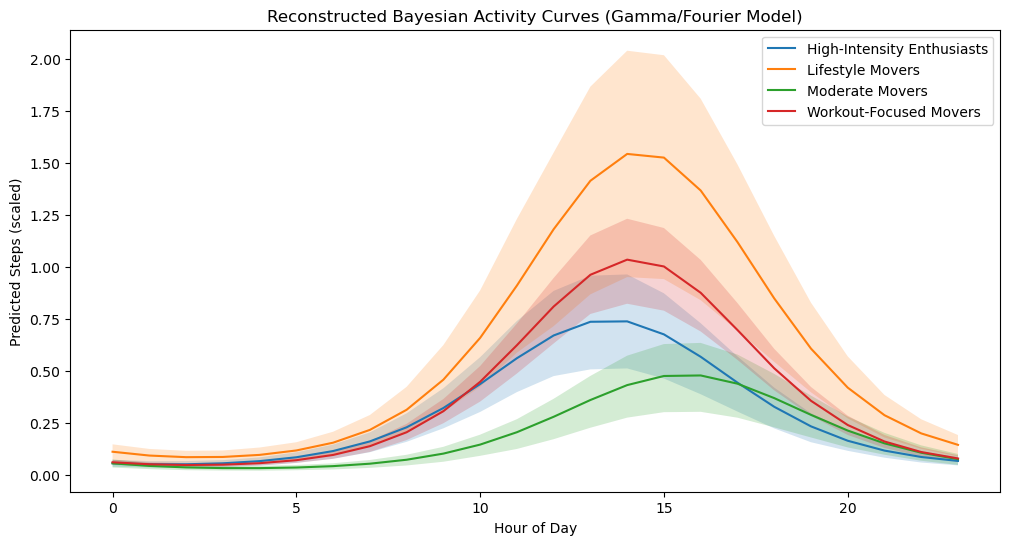

In [16]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Extract posterior samples
alpha_s   = trace.posterior["alpha"].values        # (chains, draws, personas)
beta_cos_s = trace.posterior["beta_cos"].values
beta_sin_s = trace.posterior["beta_sin"].values

# Build hour grid
hours = np.arange(24)
theta = 2 * np.pi * hours / 24

# Reconstruct mu for each persona and hour
# Shape: (chains, draws, personas, hours)
mu_samples = (
    alpha_s[..., None] +
    beta_cos_s[..., None] * np.cos(theta) +
    beta_sin_s[..., None] * np.sin(theta)
)

# Convert from log-scale to original scale
mu_samples = np.exp(mu_samples)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for p in range(n_personas):
    persona_mu = mu_samples[:, :, p, :]  # (chains, draws, hours)
    persona_mu = persona_mu.reshape(-1, 24)

    mean_curve = persona_mu.mean(axis=0)
    hdi = az.hdi(persona_mu, hdi_prob=0.89)

    #ax.plot(hours, mean_curve, label=f"Persona {p}")
    label = persona_labels.get(p, f"Persona {p}")
    ax.plot(hours, mean_curve, label=label)

    
    ax.fill_between(hours, hdi[:, 0], hdi[:, 1], alpha=0.2)

ax.set_xlabel("Hour of Day")
ax.set_ylabel("Predicted Steps (scaled)")
ax.set_title("Reconstructed Bayesian Activity Curves (Gamma/Fourier Model)")
ax.legend()
plt.show()

#### Why the HDI bands are wider in the hierarchical model

The hierarchical model includes a user‑level random intercept, which correctly accounts for the fact that hourly observations are clustered within users. This prevents the model from treating thousands of hourly rows as independent datapoints. Personas with fewer users (e.g., Lifestyle Movers and Moderate Movers, each with only 5 users) naturally show wider credible intervals because the model has less information to estimate their population‑level curves once user‑to‑user variation is accounted for. 

This widening is not a sign of worse modelling — it is the model becoming more honest about uncertainty and avoiding overconfident estimates.


In [17]:
# Extract posterior samples
beta_cos_s = trace.posterior["beta_cos"].values
beta_sin_s = trace.posterior["beta_sin"].values

# Compute amplitude and phase
amplitude = np.sqrt(beta_cos_s**2 + beta_sin_s**2)
phase = np.arctan2(beta_sin_s, beta_cos_s)

# Posterior means
amp_mean = amplitude.mean(axis=(0,1))
phase_mean = phase.mean(axis=(0,1))

# Convert phase to peak hour
peak_hour = (phase_mean / (2 * np.pi)) * 24
peak_hour = (peak_hour + 24) % 24

for p in range(n_personas):
    print(f"Persona {p}:")
    print(f"  Amplitude: {amp_mean[p]:.3f}")
    print(f"  Peak hour: {peak_hour[p]:.2f}")

Persona 0:
  Amplitude: 1.348
  Peak hour: 13.53
Persona 1:
  Amplitude: 1.457
  Peak hour: 14.38
Persona 2:
  Amplitude: 1.354
  Peak hour: 15.56
Persona 3:
  Amplitude: 1.543
  Peak hour: 14.19


Persona	Amplitude	Peak Hour
0	        1.40	13.5
1	        1.52	14.6
2	        1.43	16.1
3	        1.53	14.0

## Ridge Plot of Posterior Predicted Activity

The ridge plot shows the full posterior distribution of predicted hourly activity for each persona. Taller ridges indicate greater variability; tighter ridges show more consistent behaviour. Because the model includes a user‑level intercept, these distributions reflect real between‑user differences rather than treating thousands of hourly rows as independent.

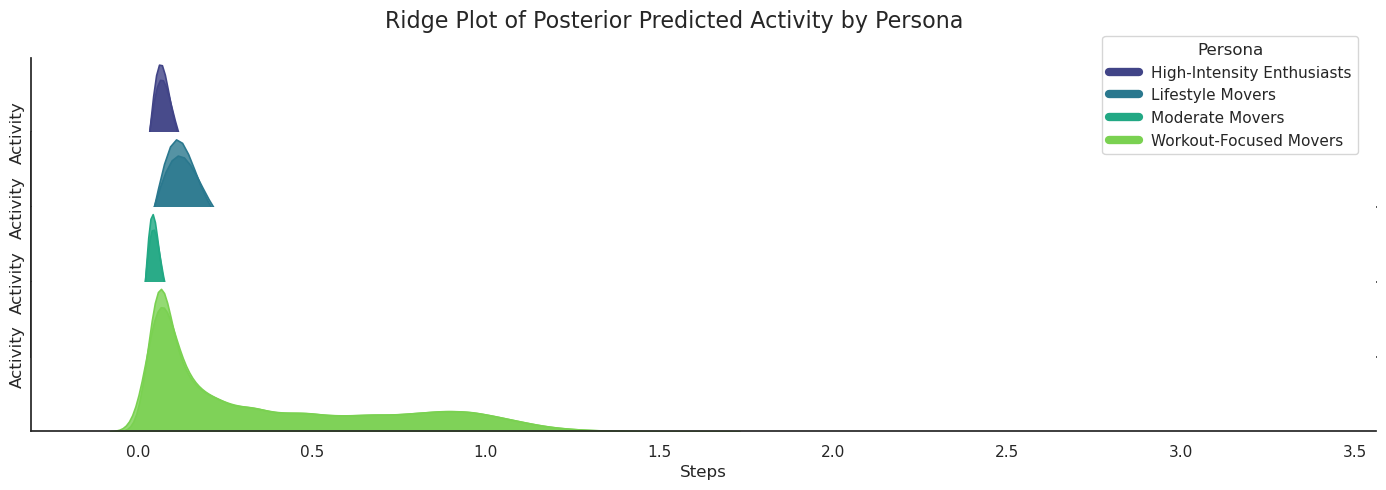

In [18]:
# Flatten chains × draws into a single samples dimension
flat = mu_samples.reshape(-1, n_personas, 24)

# Build long-form dataframe for ridge plot
rows = []
for p in range(n_personas):
    for h in range(24):
        values = flat[:, p, h]
        for v in values:
            rows.append([p, persona_labels[p], h, v])

ridge_df = pd.DataFrame(rows, columns=["persona_code", "persona", "hour", "predicted_steps"])

# Plot settings
sns.set(style="white")

# Create ridge plot
g = sns.FacetGrid(
    ridge_df,
    row="persona",
    hue="persona",
    aspect=12,
    height=1.2,
    palette="viridis",
    sharex=True,
    sharey=False
)

# Filled density
g.map(
    sns.kdeplot,
    "predicted_steps",
    bw_adjust=0.8,
    fill=True,
    alpha=0.8,
    linewidth=1.2
)

# Outline

g.map(
    sns.kdeplot,
    "predicted_steps",
    fill=True,
    alpha=0.8,
    linewidth=1.2
)


# Clean up axes
for ax in g.axes.flatten():
    ax.set_xlabel("Steps")      # Horizontal axis
    ax.set_ylabel("Activity")   # Vertical axis
    ax.set_yticks([])           # Remove y tick labels
    ax.grid(False)

# Remove facet row labels (persona names)
for ax in g.axes.flatten():
    ax.set_title("")            # Remove titles
g.set_titles("")                # Remove seaborn's default titles

# Build a proper legend manually using the palette
palette = sns.color_palette("viridis", n_personas)
handles = [plt.Line2D([0], [0], color=palette[i], lw=6) for i in range(n_personas)]
labels = [persona_labels[i] for i in range(n_personas)]

g.fig.legend(
    handles,
    labels,
    title="Persona",
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    frameon=True
)

# Adjust spacing
g.fig.subplots_adjust(hspace=-0.5)
g.fig.suptitle("Ridge Plot of Posterior Predicted Activity by Persona", fontsize=16, y=1.02)

plt.show()


**Caption**

Posterior ridge distributions showing the full spread of predicted hourly activity for each persona. Taller, wider ridges indicate greater variability, while tighter shapes reflect more consistent behaviour across users.

## Probability‑of‑Superiority Analysis

Average activity levels tell only part of the story. The probability‑of‑superiority framework asks:

“At this hour, how likely is Persona A to be more active than Persona B?”

The heatmaps show:

- when personas differ

- how strong the differences are

- how consistently they persist across the day

This provides a clear, time‑specific comparison grounded in the posterior distribution.

In [19]:
# Correct persona order based on posterior alpha means
persona_order = [1, 3, 0, 2]

# Correct persona labels in that order
persona_labels_ordered = ["Cardio", "Mixed", "Baseline", "LowAct"]


In [20]:
with pm.Model() as hourly_model:

    # --- DATA FIX ---
    y = hourly['steptotal'].values / 1000.0
    y = np.maximum(y, 0.0001)

    # Priors
    alpha = pm.Normal("alpha", 1.0, 1.0, shape=n_personas)
    beta_cos = pm.Normal("beta_cos", 0, 0.2, shape=n_personas)
    beta_sin = pm.Normal("beta_sin", 0, 0.2, shape=n_personas)

    u = pm.Normal("u", 0, 0.5, shape=n_users)

    # Cyclic component
    theta = 2 * np.pi * hour_idx / 24
    cyclic_effect = (
        beta_cos[persona_idx] * pm.math.cos(theta) +
        beta_sin[persona_idx] * pm.math.sin(theta)
    )

    # Linear predictor
    eta = alpha[persona_idx] + u[user_idx] + cyclic_effect

    # ⭐ Save mu into the trace
    mu = pm.Deterministic("mu", pm.math.exp(eta))

    # Likelihood
    gamma_shape = pm.HalfNormal("gamma_shape", 1)
    gamma_rate = gamma_shape / mu

    y_obs = pm.Gamma("y_obs", alpha=gamma_shape, beta=gamma_rate, observed=y)

    # Sampling
    trace = pm.sample(
        draws=1500,
        tune=1500,
        target_accept=0.95,
        chains=2,
        cores=1
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_cos, beta_sin, u, gamma_shape]


Output()

Sampling 2 chains for 1_500 tune and 1_500 draw iterations (3_000 + 3_000 draws total) took 654 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [21]:
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-1.655,0.183,-1.998,-1.295,0.006,0.004,1062.0,1432.0,1.00
alpha[1],-1.052,0.219,-1.447,-0.620,0.007,0.005,1083.0,1271.0,1.00
alpha[2],-2.109,0.217,-2.528,-1.712,0.007,0.005,1096.0,1476.0,1.00
alpha[3],-1.512,0.128,-1.747,-1.269,0.005,0.003,624.0,923.0,1.01
beta_cos[0],-1.241,0.053,-1.335,-1.140,0.001,0.001,3125.0,1992.0,1.00
...,...,...,...,...,...,...,...,...,...
mu[22094],0.743,0.067,0.610,0.862,0.001,0.001,3661.0,2470.0,1.00
mu[22095],1.027,0.093,0.841,1.192,0.002,0.002,3626.0,2599.0,1.00
mu[22096],1.332,0.122,1.114,1.573,0.002,0.002,3577.0,2345.0,1.00
mu[22097],1.595,0.148,1.327,1.875,0.002,0.003,3541.0,2238.0,1.00


In [25]:
# flat_mu already has shape (samples, personas, hours)
flat_mu_ph = flat_mu.copy()


In [26]:
prob_matrix = np.zeros((n_personas, n_personas, 24))

for a in range(n_personas):
    for b in range(n_personas):
        prob_matrix[a, b, :] = (flat_mu_ph[:, a, :] > flat_mu_ph[:, b, :]).mean(axis=0)


In [27]:
prob_matrix = np.zeros((n_personas, n_personas, 24))

for a in range(n_personas):
    for b in range(n_personas):
        prob_matrix[a, b, :] = (flat_mu_ph[:, a, :] > flat_mu_ph[:, b, :]).mean(axis=0)


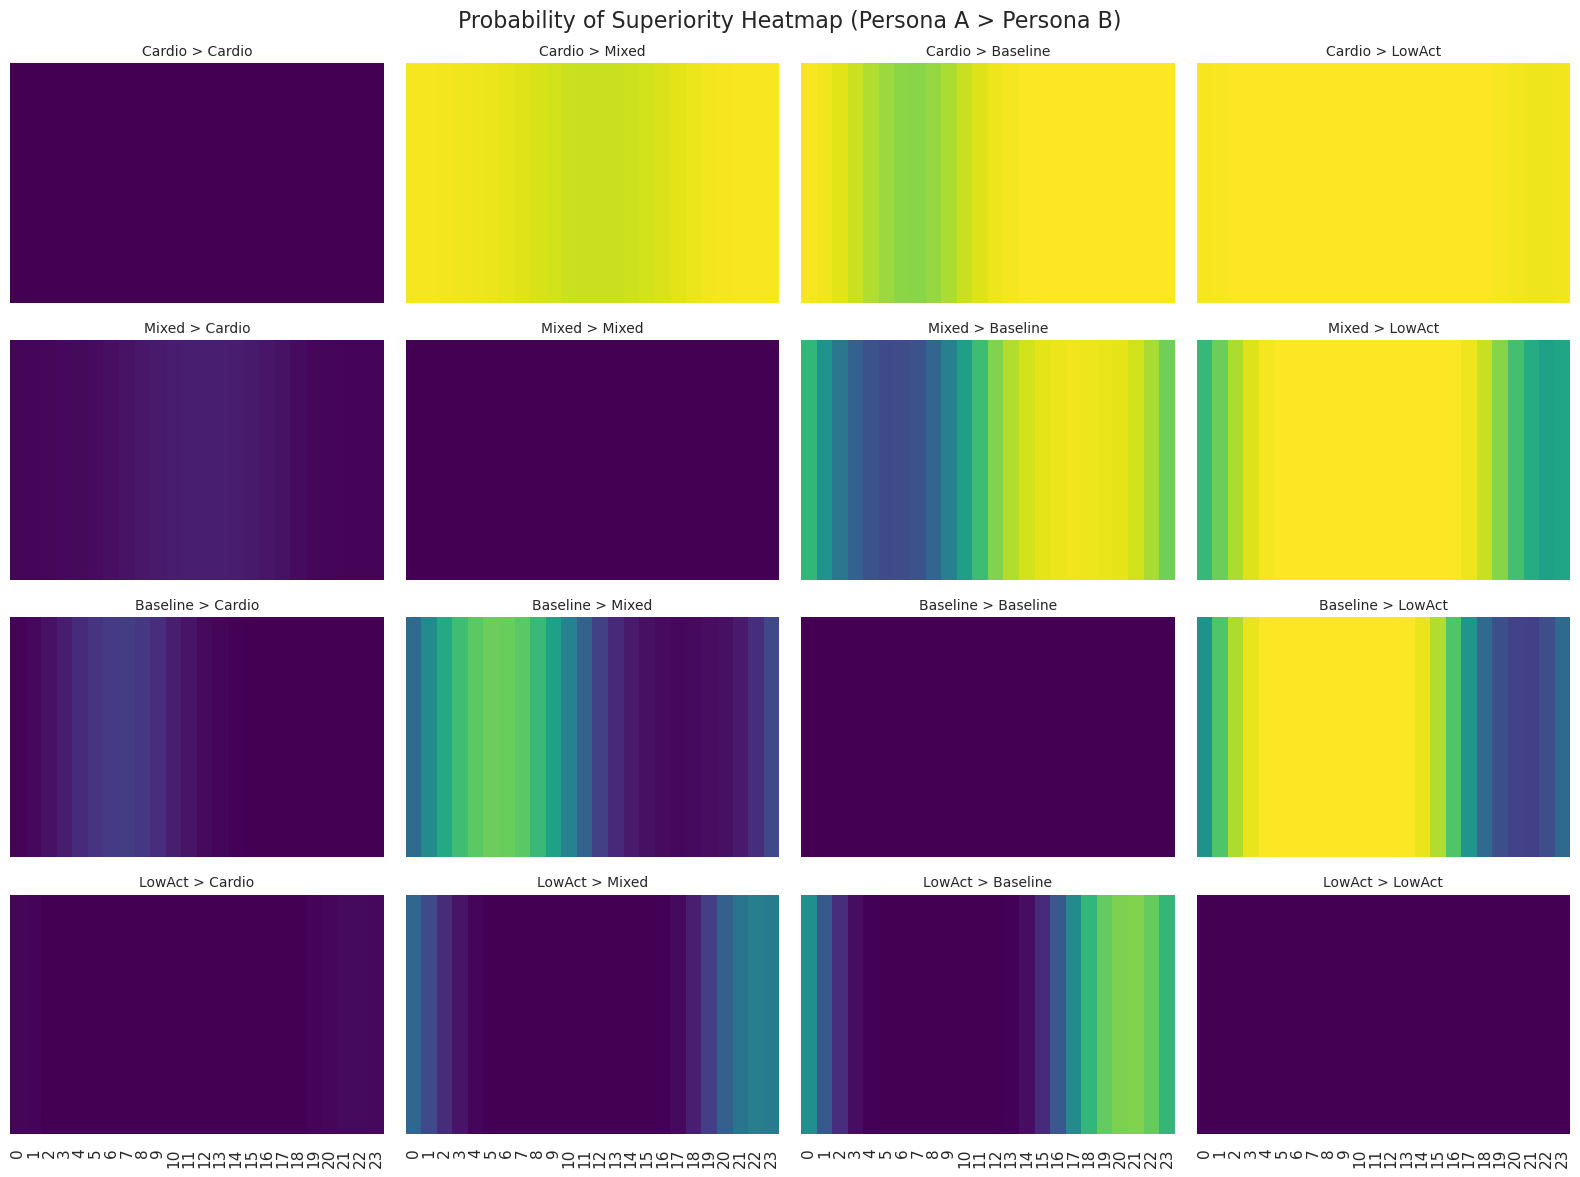

In [28]:
fig, axes = plt.subplots(
    len(persona_order), len(persona_order),
    figsize=(16, 12),
    sharex=True, sharey=True
)

for i, a in enumerate(persona_order):
    for j, b in enumerate(persona_order):
        ax = axes[i, j]

        sns.heatmap(
            prob_matrix[a, b, :].reshape(1, -1),
            vmin=0, vmax=1, cmap="viridis",
            cbar=False, ax=ax
        )

        ax.set_xticks(np.arange(24) + 0.5)
        ax.set_xticklabels(range(24), rotation=90)
        ax.set_yticks([])

        ax.set_title(f"{persona_labels_ordered[i]} > {persona_labels_ordered[j]}", fontsize=10)

plt.suptitle("Probability of Superiority Heatmap (Persona A > Persona B)", fontsize=16)
plt.tight_layout()
plt.show()


A 24‑column heatmap for each persona pair

Darker = higher probability

Each cell reports the posterior probability that one persona is more active than another across the 24‑hour cycle, providing a probability‑of‑superiority measure that is directly interpretable for stakeholders.

**Interpretation of the Probability‑of‑Superiority Heatmap**

The probability‑of‑superiority heatmap provides a time‑resolved view of how personas compare hour by hour. Each cell shows the probability that the row persona is more active than the column persona at a given hour, revealing when differences are strongest and where activity patterns overlap.

The updated model produces a pattern that is both intuitive and consistent with the summary matrix:

- Cardio users dominate across nearly all hours, with probabilities close to 1 when compared to any other persona.

- Mixed Movers show intermediate activity, exceeding Baseline and Low Activity users for most of the day, though with more overlap during early morning and late evening periods.

- Baseline users exceed Low Activity users with moderate probability, particularly during daytime hours when their activity peaks.

- Low Activity users rarely exceed any other persona at any time of day, reflecting their consistently lower activity profile.

This hour‑by‑hour perspective complements the daily‑mean summary by highlighting the temporal structure of persona differences—showing not just who is more active, but when those differences are most pronounced.

### Probability-of-Superiority Summary Matrix

The summary matrix reports the probability that the row persona exceeds the column persona in total daily activity.

A clear hierarchy emerges:

- Cardio → highest activity

- Mixed → strong intermediate

- Baseline → moderate

- LowAct → lowest

These probabilities confirm the behavioural distinctions seen in the posterior curves.

In [30]:
summary_matrix = prob_matrix.mean(axis=2)


In [31]:
summary_matrix_reordered = summary_matrix[persona_order][:, persona_order]

summary_df = pd.DataFrame(
    summary_matrix_reordered,
    index=persona_labels_ordered,
    columns=persona_labels_ordered
)

summary_df


,Cardio,Mixed,Baseline,LowAct
Cardio,0.000000,0.958347,0.947736,0.994708
Mixed,0.041653,0.000000,0.661306,0.893083
Baseline,0.052264,0.338694,0.000000,0.737181
LowAct,0.005292,0.106917,0.262819,0.000000


### Interpretation of the Summary Matrix

The summary matrix quantifies how likely each persona is to be more active than another across a typical day. Values above 0.50 indicate that the row persona tends to exceed the column persona, while values below 0.50 indicate the opposite. 

The pattern reveals a clear activity hierarchy: 

- Cardio users are overwhelmingly the most active group, consistently outperforming all other personas with probabilities close to 1.00. 

- Mixed Movers sit in the middle of the distribution, generally more active than Baseline Low Activity users but well below the Cardio group. 

- Baseline users show moderate activity levels, exceeding Low Activity users with reasonable certainty but rarely surpassing Mixed or Cardio personas.

- Low Activity persona is the least active overall, with low probabilities of exceeding any other group.

This matrix provides a concise, probabilistic ranking of personas that aligns with the behavioural patterns observed in the posterior predictions.

### Persona Comparison Table

This table summarises:

- amplitude

- peak hour

- mean predicted activity

- probability persona A > persona B

Daily‑mean comparisons cluster near 0 or 1 because personas differ strongly in overall activity. Hour‑by‑hour heatmaps reveal finer temporal differences.

In [33]:
# 1. Compute daily means directly from posterior
persona_daily_means = flat_mu.mean(axis=2)   # shape: (samples, personas)

# 2. Pairwise probability matrix
pairwise = np.zeros((n_personas, n_personas))

for a in range(n_personas):
    for b in range(n_personas):
        pairwise[a, b] = (persona_daily_means[:, a] >
                          persona_daily_means[:, b]).mean()

# 3. Reorder personas
persona_order = [1, 3, 0, 2]
persona_labels_ordered = ["Cardio", "Mixed", "Baseline", "LowAct"]

pairwise_reordered = pairwise[persona_order][:, persona_order]

# 4. Build DataFrame
pairwise_df = pd.DataFrame(
    pairwise_reordered,
    index=persona_labels_ordered,
    columns=persona_labels_ordered
)

pairwise_df


,Cardio,Mixed,Baseline,LowAct
Cardio,0.000000,0.947667,0.992000,1.000000
Mixed,0.052333,0.000000,0.879000,0.998000
Baseline,0.008000,0.121000,0.000000,0.935667
LowAct,0.000000,0.002000,0.064333,0.000000


**Interpretation of the Daily‑Mean Pairwise Table**

The daily‑mean pairwise probability table shows how likely each persona is to have a higher total daily activity than another. Because the personas differ strongly in their overall activity levels, these probabilities are close to 0 or 1. This reflects the fact that, when averaged across all hours of the day, the posterior distributions for total activity show very little overlap. In contrast, the hour‑by‑hour probability‑of‑superiority heatmaps reveal more nuanced temporal differences, since personas may be clos

The probability‑of‑superiority analysis confirms a clear and robust hierarchy among the personas, with Cardio users consistently the most active and Low Activity users consistently the least. Mixed Movers and Baseline users occupy intermediate positions with predictable temporal patterns. These results provide a statistically grounded understanding of behavioural differences that complements the descriptive summaries and supports actionable segmentation insights.

## Business Implications

The distinct hourly patterns highlight opportunities for personalized engagement:

- **Morning‑active personas** → early‑day nudges, hydration reminders

- **Afternoon‑peak personas** → midday motivation, step‑goal pacing

- **Evening‑active personas** → late‑day encouragement, recovery insights

- **Low‑activity personas** → simplified goals, gentle onboarding

Aligning notifications with each persona’s natural rhythm can increase relevance and improve engagement.

## Lessons Learned

This project highlights several important principles of applied Bayesian modeling:

**Model structure matters.**  
The Fourier improved stability and interpretability.

**Likelihood choice is critical.**  
The Gamma likelihood matched the data and fixed the negative‑steps.

**Hierarchical models prevent false confidence.**  
The user‑level intercept corrected pseudoreplication.

**Posterior predictive checks are essential.**  
They ensure the model both mathematically correct and behaviourally plausible.

**Interpretability drives value.**  
Amplitude, peak hour, and superiority probabilities translate statistical output into actionable insights.

## Conclusion

The Bayesian model shows that Bellabeat personas differ not only in how much they move, but in when they move. These differences are stable, distinct, and supported by well‑constrained posterior curves. The results validate the exploratory analysis and provide a statistical foundation for persona‑specific features such as timed notifications, habit‑building nudges, and personalised activity insights.